# Transshipments

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pycountry

In [3]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.2)
color = sns.color_palette("tab10", 10)[0]

In [4]:
wd = "/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/"

In [5]:
carrier = pd.read_excel(wd + 'port_evaluation/data/proc/GFW/gfw_data-v2.xlsx', sheet_name='carriers')
loiter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/loitering.csv')
encounter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/encounter.csv')
port_visit = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_2690/987954189.py:2: DtypeWarning: Columns (10,11,12,13,14,41,42,43,46) have mixed types. Specify dtype option on import or set low_memory=False.
  loiter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/loitering.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_2690/987954189.py:3: DtypeWarning: Columns (43,46,53) have mixed types. Specify dtype option on import or set low_memory=False.
  encounter = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/encounter.csv')
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_2690/987954189.py:4: DtypeWarning: Columns (6,7,8,9,12,22,25,26,29,33,34,35,37,38,41,42,43,44,46,47,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  port_visit = pd.read_csv(wd + 'port_evaluation/data/input/GFW/unified/port_visit.csv')


In [6]:
loiter2 = pd.read_excel(wd + 'port_evaluation/data/proc/GFW/gfw_data-v2.xlsx', sheet_name='loitering') ## data that contains average distance to shore

In [7]:
eez = pd.read_csv(wd + 'port_evaluation/data/input/EEZ/eez.csv')

In [8]:
country_data = [[country.alpha_3, country.alpha_2, country.name] for country in pycountry.countries]
country_data = pd.DataFrame(country_data, columns=['alpha_3', 'alpha_2', 'flag_country'])
rename_dict = {'Korea, Republic of': 'Korea', 'Taiwan, Province of China': 'Taiwan', 'Russian Federation': 'Russia'}
for country in rename_dict.keys():
    country_data.loc[country_data['flag_country'] == country, 'flag_country'] = rename_dict[country]

Preprocessing

In [9]:
## merging loitering with carrier data
carrier['imo'] = carrier['imo'].replace(0,np.nan)
carriers = carrier.merge(country_data, left_on='flag', right_on='alpha_3', how='left')
loitering = loiter.merge(carriers, left_on='vessel.id', right_on='id', how='left', suffixes=('_loitering', '_carrier')) ## all but 2 vessel.ids match between datasets.

Summary statistics

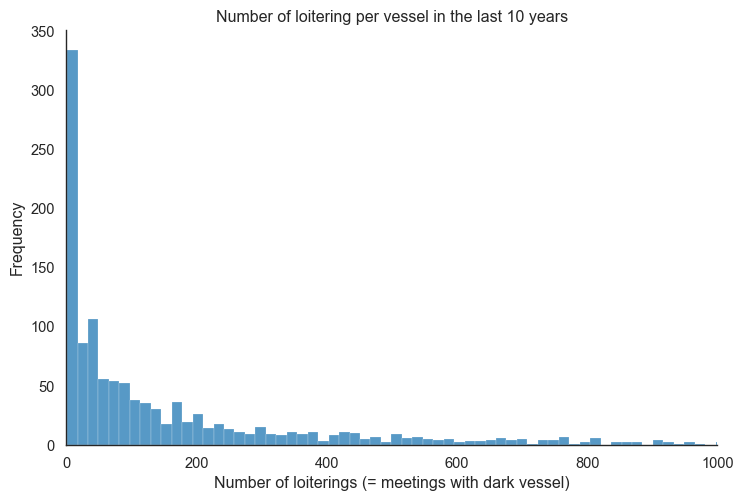

The median is 73.0.


In [10]:
plot_data = loitering.loc[:,'imo'].value_counts().reset_index()
sns.displot(data=plot_data, x="imo", kind="hist", bins = 300, aspect = 1.5)
plt.xlim(0,1000) 
plt.title('Number of loitering per vessel in the last 10 years')
plt.xlabel('Number of loiterings (= meetings with dark vessel)')
plt.ylabel('Frequency')
plt.show()
print("The median is {median}.".format(median=plot_data['imo'].median()))

Share responsible

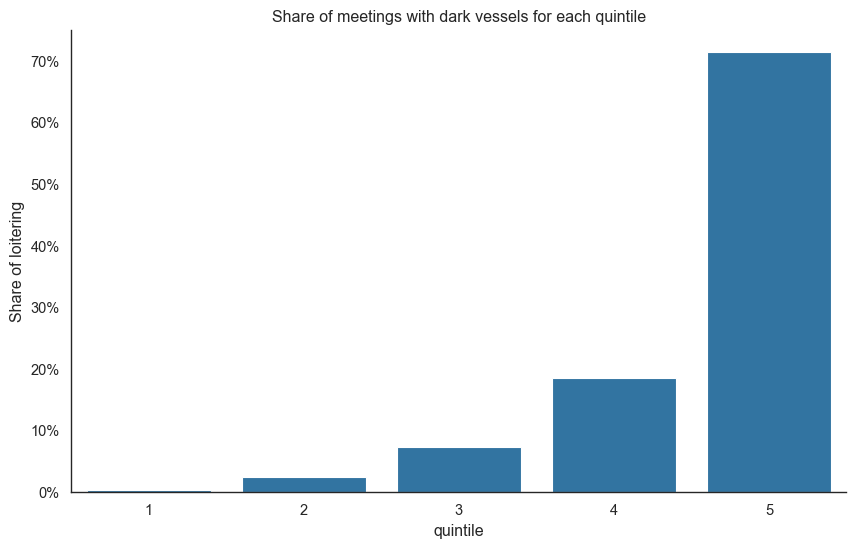

In [11]:
running_sum = 0
sum = []
share = []
for quintile in range(0,5):
    quantile = (quintile + 1)/5
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'quintile' : range(1,6), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "quintile",
              y = "share",
              data = quintiles,
              ax = ax,
              color=color)
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Share of meetings with dark vessels for each quintile')
plt.show()

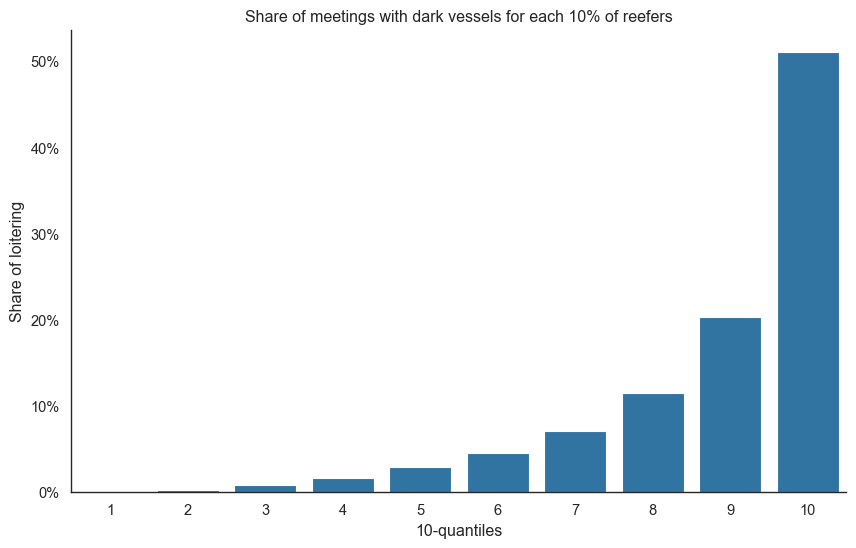

In [12]:
running_sum = 0
sum = []
share = []
for quintile in range(0,10):
    quantile = (quintile + 1)/10
    amount = plot_data['imo'].quantile(quantile)
    sum.append(plot_data.loc[plot_data['imo']<=amount,'imo'].sum() - running_sum)
    running_sum += sum[-1]
    share.append(sum[-1]/plot_data['imo'].sum() * 100)
quintiles = pd.DataFrame({'10-quantiles' : range(1,11), 'share': share})

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x = "10-quantiles",
              y = "share",
              data = quintiles,
              ax = ax,
              color=color)
handles, labels = ax.get_legend_handles_labels()
sns.despine(right = True)
plt.ylabel('Share of loitering')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Share of meetings with dark vessels for each 10% of reefers')
plt.show()

Cutoff for loitering

In [13]:
plot_data['imo'].quantile(.9)

546.8000000000002

Number of ships

In [14]:
len(plot_data.loc[plot_data['imo']>=549.49,'imo'])

120

In [32]:
top_10_percent = plot_data.loc[plot_data['imo']>=549.49,:]
loitering_top = loitering.loc[loitering['imo'].isin(top_10_percent['index']),:]
loitering_top.to_csv(wd + 'port_evaluation/data/proc/GFW/top10percent.csv')

In [16]:
plot_data2 = top_10_percent.rename({'imo': 'n_dark_meetups'}, axis=1).merge(carriers, how='left', left_on='index', right_on='imo')
plot_data3 = plot_data2.groupby('flag_country')['imo'].nunique().reset_index().sort_values('imo')
# sns.displot(data=plot_data2, x="flag", kind="hist", bins = 300, aspect = 1.5)
# plt.show()

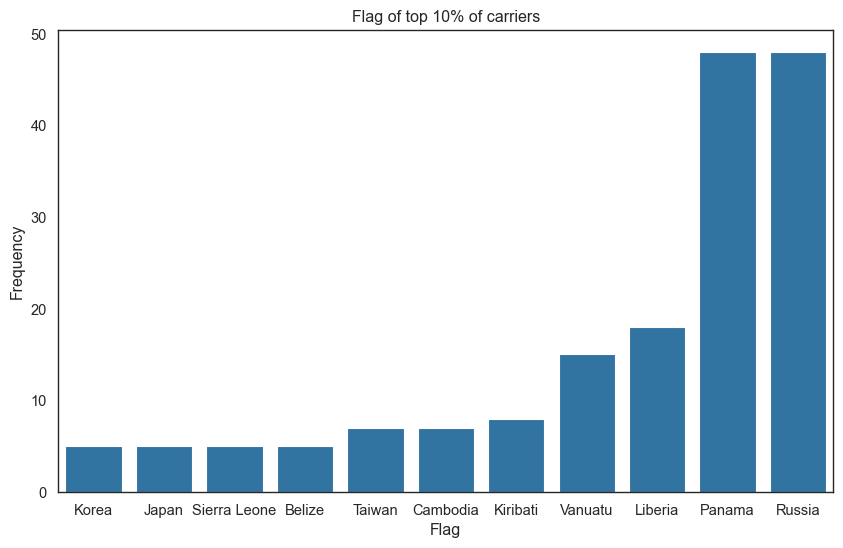

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data3.iloc[21:,:], 
    x='flag_country', 
    y='imo', 
    ax = ax,
    color=color)
plt.title('Flag of top 10% of carriers')
plt.ylabel('Frequency')
plt.xlabel('Flag')
plt.show()

Time

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_2690/1922207913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loitering_top['start_dt'] = pd.to_datetime(loitering_top['start'])
/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_2690/1922207913.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loitering_top['year'] = loitering_top['start_dt'].dt.year


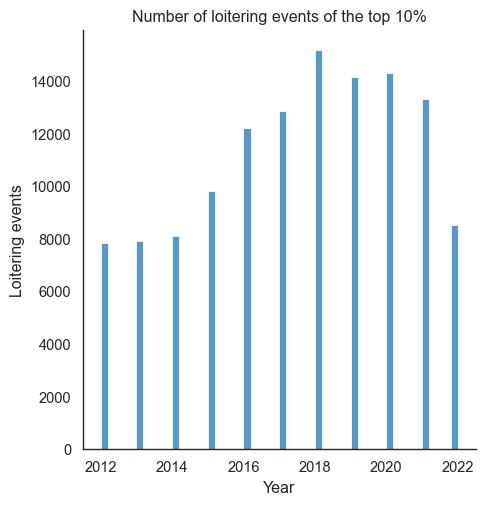

In [18]:
loitering_top['start_dt'] = pd.to_datetime(loitering_top['start'])
loitering_top['year'] = loitering_top['start_dt'].dt.year
sns.displot(data=loitering_top, x="year", kind="hist")
plt.title('Number of loitering events of the top 10%')
plt.ylabel('Loitering events')
plt.xlabel('Year')
plt.show()

Additional analysis:

- which boats they each encountered
- length and size (using SeaVision)

## Location of meetups

EEZ

In [19]:
loiter2['averageDistanceFromShorenm'] = loiter2['averageDistanceFromShoreKm'] / 1.852

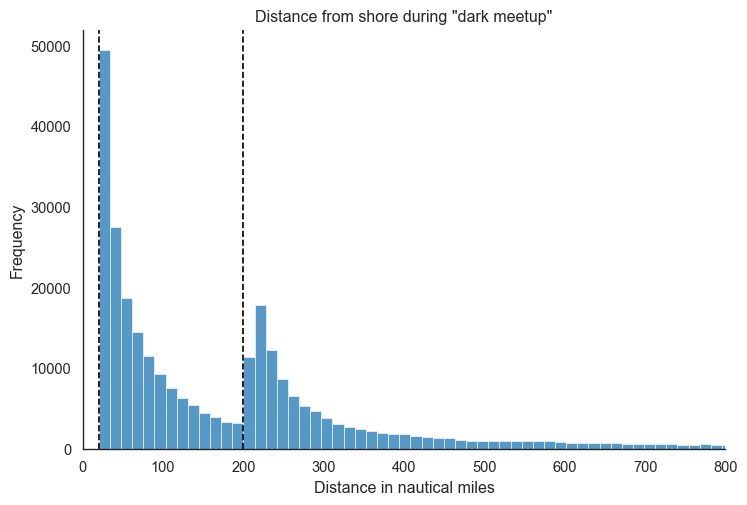

In [20]:
fig = sns.displot(data=loiter2, x="averageDistanceFromShorenm", kind="hist", bins = 100, aspect = 1.5)
plt.axvline(200,c='black',linestyle='--')
plt.axvline(20,c='black',linestyle='--')
plt.xlim(0,800) 
plt.title('Distance from shore during "dark meetup"')
plt.xlabel('Distance in nautical miles')
plt.ylabel('Frequency')
plt.show()

In [21]:
loiter2['eez'].isna().sum()/len(loiter2)

0.4066901785523056

40% of dark meet-ups in EEZ

In [22]:
plot_data4 = loiter2.groupby('eez')['event_id'].nunique().reset_index().sort_values('event_id')
plot_data4 = plot_data4.set_index(plot_data4.columns.drop('eez',1).tolist()) \
    .eez.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'eez'}) \
    .loc[:, plot_data4.columns] \
    .groupby('eez')['event_id'] \
    .sum() \
    .reset_index() \
    .sort_values('event_id')

In [23]:
eez['MRGID_new'] = eez['MRGID'].astype(str)

In [24]:
plot_data4 = plot_data4.merge(eez, left_on='eez', right_on='MRGID_new', how='left').reset_index(drop=True)

In [25]:
additional = {
    '8487': 'Japanese Exclusive Economic Zone',
    '8492': 'Indonesian Exclusive Economic Zone',
    '48950': 'Kuril Islands (Japan v. Russia)',
    '8471': 'Guinea Bissau Exclusive Economic Zone',
    '8463': 'United States Exclusive Economic Zone (Alaska)',
    '8488': 'Kiribati Exclusive Economic Zone',
    '8486': 'Chinese Exclusive Economic Zone',
    '8493': 'Canadian Exclusive Economic Zone',
}
for eez in additional.keys():
    plot_data4.loc[plot_data4['eez']==eez, 'preferredGazetteerName'] = additional[eez]
# for row in range(len(plot_data4)):
plot_data4['preferredGazetteerName'] = \
    plot_data4['preferredGazetteerName'] \
        .str.replace('Exclusive Economic Zone', 'EEZ')
plot_data4['preferredGazetteerName'] = \
    plot_data4['preferredGazetteerName'] \
        .str.replace('Exclusive economic Zone', 'EEZ')

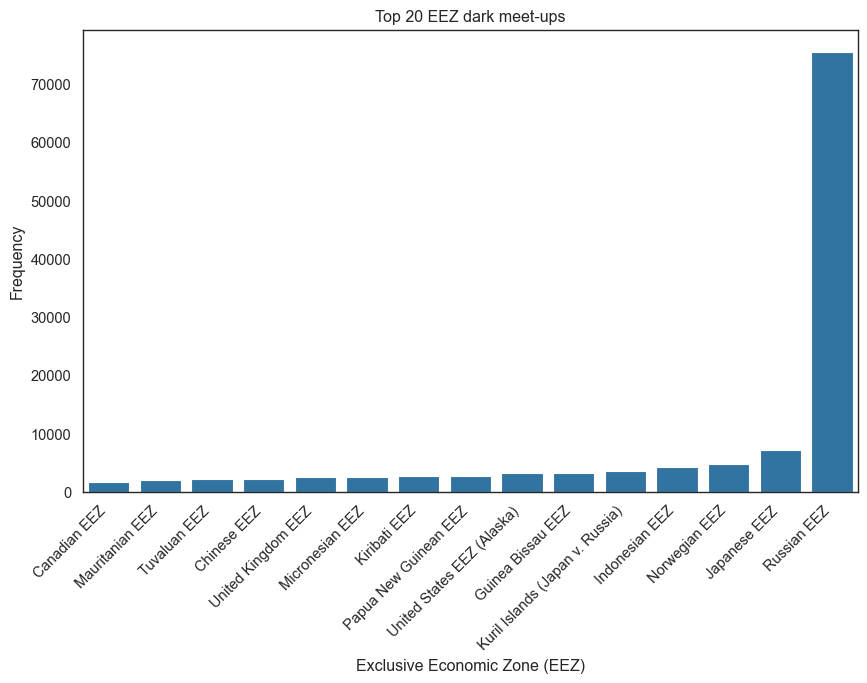

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data4.iloc[-20:,:], 
    x='preferredGazetteerName', 
    y='event_id', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 EEZ dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('Exclusive Economic Zone (EEZ)')
plt.show()

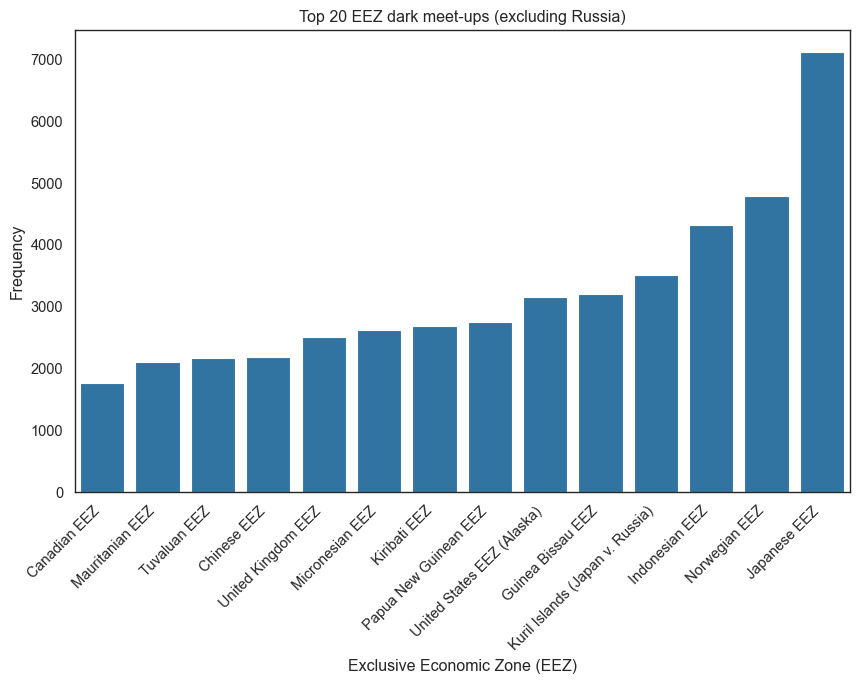

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data4.iloc[-20:-1,:], 
    x='preferredGazetteerName', 
    y='event_id', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 EEZ dark meet-ups (excluding Russia)')
plt.ylabel('Frequency')
plt.xlabel('Exclusive Economic Zone (EEZ)')
plt.show()

RFMOs

In [28]:
plot_data5 = loitering \
    .rename({'regions.rfmo': 'rfmo'}, axis=1) \
    .groupby('rfmo')['id_loitering'] \
    .nunique() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split(',', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5 = plot_data5.set_index(plot_data5.columns.drop('rfmo',1).tolist()) \
    .rfmo.str.split('|', expand=True) \
    .stack() \
    .reset_index() \
    .rename(columns={0:'rfmo'}) \
    .loc[:, plot_data5.columns] \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')
plot_data5['rfmo'] = plot_data5['rfmo'].str.replace(' ','')
plot_data5 = plot_data5 \
    .groupby('rfmo')['id_loitering'] \
    .sum() \
    .reset_index() \
    .sort_values('id_loitering')  


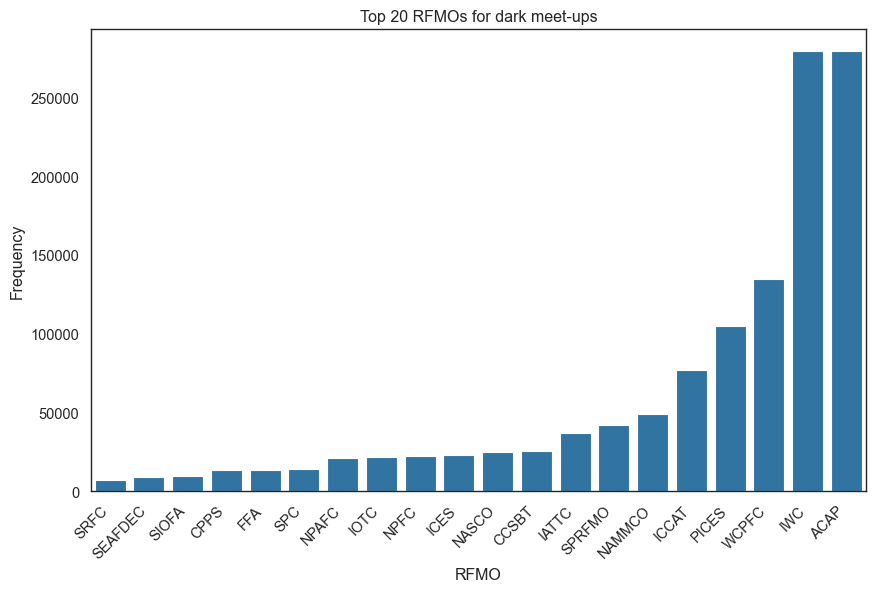

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data5.iloc[-20:,:], 
    x='rfmo', 
    y='id_loitering', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('Top 20 RFMOs for dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('RFMO')
plt.show()

In [30]:
plot_data5['loit_share'] = 100*plot_data5['id_loitering']/len(loitering)

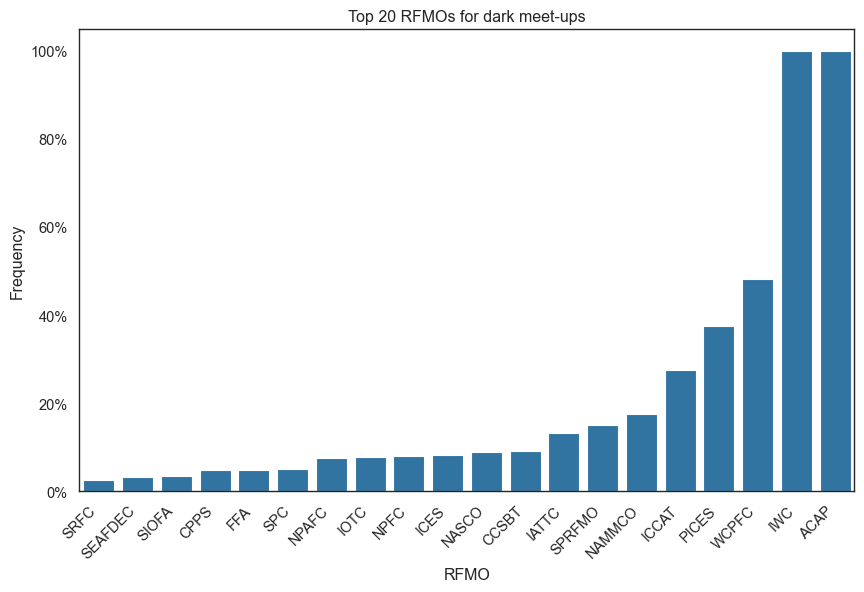

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data5.iloc[-20:,:], 
    x='rfmo', 
    y='loit_share', 
    ax = ax,
    color=color)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title('Top 20 RFMOs for dark meet-ups')
plt.ylabel('Frequency')
plt.xlabel('RFMO')
plt.show()